In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
df = pd.read_csv("../data/DSNY_Monthly_Tonnage_Data.csv")
# changing month to datetime for pandas
df['MONTH'] = pd.to_datetime(df['MONTH'])
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24647 entries, 0 to 24646
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   MONTH                24647 non-null  datetime64[ns]
 1   BOROUGH              24647 non-null  object        
 2   COMMUNITYDISTRICT    24647 non-null  int64         
 3   REFUSETONSCOLLECTED  24647 non-null  float64       
 4   PAPERTONSCOLLECTED   22213 non-null  float64       
 5   MGPTONSCOLLECTED     22570 non-null  float64       
 6   RESORGANICSTONS      3095 non-null   float64       
 7   SCHOOLORGANICTONS    2308 non-null   float64       
 8   LEAVESORGANICTONS    881 non-null    object        
 9   XMASTREETONS         1685 non-null   float64       
 10  OTHERORGANICSTONS    1933 non-null   float64       
 11  BOROUGH_ID           24647 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 2.3+ MB


/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_51833/2461424894.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['MONTH'] = pd.to_datetime(df['MONTH'])


,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,OTHERORGANICSTONS,BOROUGH_ID
0,2025-10-01,Bronx,1,3352.0,235.0,124.8,16.7,85.9,NaN,NaN,NaN,2
1,2025-10-01,Bronx,2,7942.4,231.6,213.8,20.4,100.7,NaN,NaN,NaN,2
2,2025-10-01,Bronx,3,2348.6,140.1,147.5,19.1,NaN,NaN,NaN,NaN,2
3,2025-10-01,Bronx,4,4210.4,233.3,291.1,20.8,70.7,NaN,NaN,0.3,2
4,2025-10-01,Bronx,5,3578.3,216.6,299.9,17.1,85.6,NaN,NaN,NaN,2


In [ ]:
df.groupby('BOROUGH')['COMMUNITYDISTRICT'].unique()
# staten island has only 3 community districts (the least)
# manhattan and bronx have 12
# queens and brooklyn have 14+



BOROUGH
Bronx                      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Brooklyn         [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
Manhattan                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Queens             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Staten Island                                            [1, 2, 3]
Name: COMMUNITYDISTRICT, dtype: object

<Axes: xlabel='PAPERTONSCOLLECTED', ylabel='REFUSETONSCOLLECTED'>

<Axes: xlabel='MGPTONSCOLLECTED', ylabel='REFUSETONSCOLLECTED'>

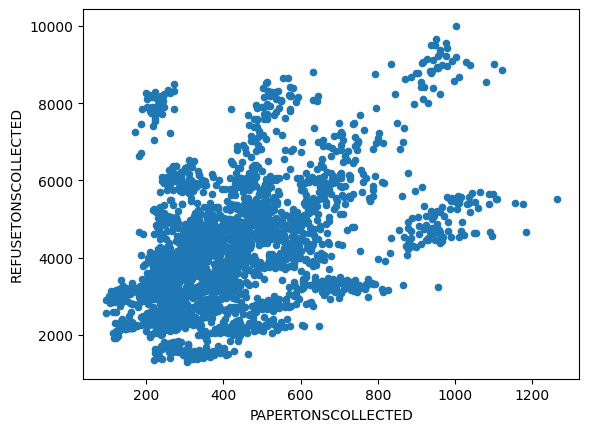

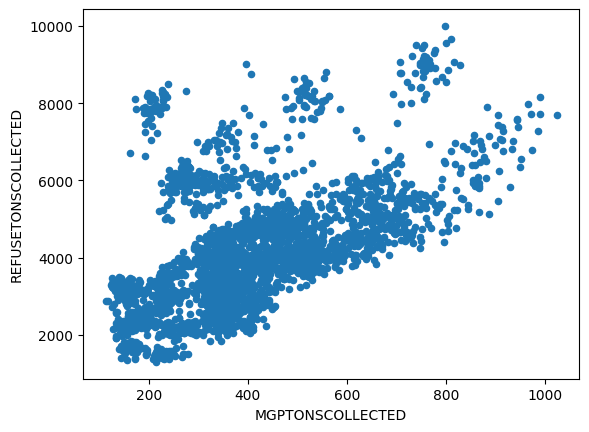

In [51]:
newdata = df[(df['MONTH'] >= '2022-01-01')]

# plots of both papers and mgptons are linear
display(newdata.plot(kind='scatter',x='PAPERTONSCOLLECTED',y='REFUSETONSCOLLECTED'))
display(newdata.plot(kind='scatter',x='MGPTONSCOLLECTED',y='REFUSETONSCOLLECTED'))

/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_51833/810678896.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata['paperxmgp'] = (newdata['PAPERTONSCOLLECTED'] * newdata['MGPTONSCOLLECTED'])


<Axes: xlabel='paperxmgp', ylabel='REFUSETONSCOLLECTED'>

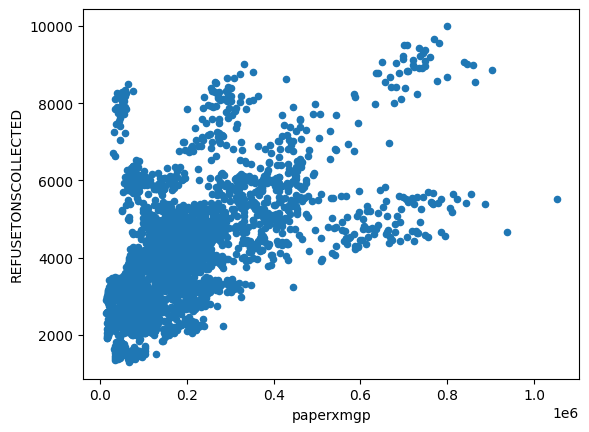

In [57]:
# this is multicollinearity if we plot against refusetons
newdata['paperxmgp'] = (newdata['PAPERTONSCOLLECTED'] * newdata['MGPTONSCOLLECTED'])

# how else can we proportionately compare

newdata.plot(kind='scatter',x='paperxmgp',y='REFUSETONSCOLLECTED')

In [ ]:
X = newdata['']